# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
!pip freeze > requirements.txt

In [2]:
!python -V

Python 3.10.0


In [3]:
!free

'free' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, count, avg, sum as Fsum, approx_count_distinct, max, min, first
from pyspark.sql.types import IntegerType, FloatType, StringType
import datetime

import datetime
import time
import os
import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
# # create a Spark session
# spark = SparkSession \
#     .builder \
#     .appName("Sparkify Project") \
#     .getOrCreate()

In [6]:
spark = SparkSession.builder \
    .appName("MySparkJob") \
    .config("spark.executor.memory", "24g") \
    .config("spark.driver.memory", "14g") \
    .config("spark.executor.cores", "12") \
    .config("spark.num.executors", "14") \
    .config("spark.network.timeout", "120s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

In [7]:
spark.sparkContext.getConf().getAll()

[('spark.executor.memory', '24g'),
 ('spark.app.startTime', '1734581178617'),
 ('spark.driver.port', '59026'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=f

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
# load in the dataset
df = spark.read.json("mini_sparkify_event_data.json")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### `extract_features(df)`
This function processes the Spark DataFrame containing user activity logs to extract meaningful features for modeling. 

- **Input**: A Spark DataFrame with raw user activity data.
- **Output**: A Spark DataFrame with aggregated features, including:
  - **Songs Listened**: Total songs played by the user.
  - **Unique Artists**: Number of unique artists listened to.
  - **Thumbs Up/Down**: Number of likes and dislikes given by the user.
  - **Friends Added/Playlists Added**: Number of interactions with friends and playlists.
  - **Errors**: Number of errors encountered.
  - **Membership Duration**: Duration of the user's membership.
  - **Device**: User's device type derived from the `userAgent`.
  - **Churn**: Whether the user has canceled their subscription.

It also handles missing values by imputing numerical features with the mean and categorical features with default values.


In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when, count, avg, sum as Fsum, approx_count_distinct, max, min, first, isnan
from pyspark.sql.types import IntegerType, FloatType, StringType
import datetime

def extract_features(df):
    """
    Extracts features from a Spark DataFrame containing user activity data.

    Args:
        df (DataFrame): Input Spark DataFrame with user activity logs.

    Returns:
        DataFrame: A Pandas DataFrame containing aggregated features for each user.
    """

    # Step 1: Clean the data by removing rows with missing userId or sessionId, and filtering out empty userIds
    df_cleaned = df.dropna(subset=["userId", "sessionId"]).filter(df["userId"] != "")

    # Step 2: Define necessary UDFs
    get_datetime_str = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"), StringType())
    get_duration_days = udf(lambda x, y: float((x - y) / (1000 * 60 * 60 * 24)), FloatType())

    # Device classification based on userAgent
    def classify_device(user_agent):
        if "iPhone" in user_agent or "iPad" in user_agent:
            return "iOS"
        elif "Android" in user_agent:
            return "Android"
        elif "Windows" in user_agent:
            return "Windows"
        elif "Macintosh" in user_agent:
            return "Mac"
        elif "Linux" in user_agent:
            return "Linux"
        else:
            return "Other"

    classify_device_udf = udf(classify_device, StringType())

    # Step 3: Add a column for device type
    df_cleaned = df_cleaned.withColumn("device", classify_device_udf(col("userAgent")))

    # Step 4: Aggregate features at the user level
    features = df_cleaned.groupBy("userId").agg(
        Fsum(when(col("page") == "NextSong", 1).otherwise(0)).alias("songsListened"),
        approx_count_distinct("artist").alias("uniqueArtists"),
        Fsum(when(col("page") == "Thumbs Up", 1).otherwise(0)).alias("thumbsUp"),
        Fsum(when(col("page") == "Thumbs Down", 1).otherwise(0)).alias("thumbsDown"),
        Fsum(when(col("page") == "Add Friend", 1).otherwise(0)).alias("friendsAdded"),
        Fsum(when(col("page") == "Add to Playlist", 1).otherwise(0)).alias("playlistsAdded"),
        Fsum(when(col("page") == "Error", 1).otherwise(0)).alias("errors"),
        Fsum(when(col("page") == "Help", 1).otherwise(0)).alias("helpInteractions"),
        Fsum(when(col("page") == "Submit Upgrade", 1).otherwise(0)).alias("numUpgrades"),
        Fsum(when(col("page") == "Submit Downgrade", 1).otherwise(0)).alias("numDowngrades"),
        (max("ts") - min("registration")).alias("membershipDurationMs"),
        first("gender").alias("gender"),
        first("device").alias("device"),
        Fsum(when(col("page") == "Cancellation Confirmation", 1).otherwise(0)).alias("churn")
    )

    # Step 5: Calculate additional derived features
    features = features.withColumn("thumbsUpRatio", col("thumbsUp") / (col("thumbsUp") + col("thumbsDown")))\
                       .withColumn("songsPerArtist", col("songsListened") / col("uniqueArtists"))\
                       .withColumn("membershipDurationDays", col("membershipDurationMs") / (1000 * 60 * 60 * 24))

    # Step 6: Check for missing values
    missing_values = features.select(
        [count(when(isnan(c) | col(c).isNull(), 1)).alias(c) for c in features.columns]
    )
    # missing_values.show()  # Display columns with missing values

    # Suggested strategies for handling missing values:
    # Replace NaN in numerical columns with the mean value
    numerical_columns = ["thumbsUpRatio", "songsPerArtist", "membershipDurationDays"]
    for column in numerical_columns:
        mean_value = features.select(avg(col(column))).first()[0]
        features = features.fillna({column: mean_value})

    # Fill NaN in categorical columns with default values
    features = features.fillna({
        "gender": "Unknown",
        "device": "Unknown"
    })

    # Step 7: Convert to Pandas DataFrame for further use
    return features

In [10]:
df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [11]:
df_features = extract_features(df)

In [13]:
# df_features.toPandas().info()

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.


### Data Imbalance Issue  

Churned users account for relatively few records in the training set

| churn | count | 
|:-------|:------:|
|   0  |  173  |
|  1  |  52  |


### Evaluation Metrics  
Using accuracy alone can be misleading in imbalanced datasets. Instead, metrics such as **Precision**, **Recall**, **F1-Score**, and **ROC-AUC** are more effective in assessing performance. For multi-class problems, metrics like **macro-averaged F1-Score** or **weighted metrics** are preferable.  

### Data Sampling Methods  
To address imbalance, data sampling techniques such as **oversampling** (e.g., SMOTE, ADASYN) or **undersampling** can be applied. Oversampling focuses on increasing the representation of minority classes, while undersampling reduces the dominant class size to balance the dataset. Hybrid approaches combining both methods can also be effective.  

### Suitable Models  
Some models are inherently better at handling imbalanced data. For example:  
- **Tree-based models** (e.g., Random Forest, XGBoost) with built-in class weighting.  
- **Logistic Regression** or **SVM** with adjusted class weights.  
- **Neural Networks** using loss functions like Focal Loss or Class-Balanced Loss.  
Additionally, ensemble techniques such as **Bagging** or **Boosting** can further improve performance.  


### `train_models(features)`
This function trains and evaluates multiple classification models using the extracted features, identifies the best model, and tunes it if necessary.

- **Input**: A Spark DataFrame of extracted features with labels.
- **Models**:
  - **Logistic Regression**
  - **Random Forest Classifier**
  - **Gradient-Boosted Trees (GBT) Classifier**
- **Steps**:
  1. Assemble features into a single vector.
  2. Split data into training and test sets (80%-20%).
  3. Train each model and evaluate using accuracy.
  4. Identify the best-performing model.
  5. Perform hyperparameter tuning for Random Forest if it is the best model.
- **Output**: Prints accuracy for each model and the tuned Random Forest accuracy (if applicable).

---

### `tune_random_forest(train_data, test_data)`
This function performs hyperparameter tuning for the Random Forest Classifier using cross-validation.

- **Input**: Training and test datasets.
- **Hyperparameters Tuned**:
  - `numTrees`: Number of trees in the forest ([50, 100]).
  - `maxDepth`: Maximum depth of the tree ([5, 10]).
- **Output**: Best-tuned accuracy of the Random Forest model.

In [14]:
def split_train_test(features, seed=143):
     # Step 1: Assemble features into a single vector column
    assembler = VectorAssembler(
        inputCols=["songsListened", "uniqueArtists", "thumbsUp", "thumbsDown", "friendsAdded", "playlistsAdded", 
                   "errors", "helpInteractions", "numUpgrades", "numDowngrades", "thumbsUpRatio", 
                   "songsPerArtist", "membershipDurationDays"],
        outputCol="features"
    )
    feature_data = assembler.transform(features).select("features", col("churn").alias("label"))

    # Step 2: Split the data into training and test sets
    train_data, test_data = feature_data.randomSplit([0.8, 0.2], seed=seed)
    
    return train_data, test_data


In [15]:
def save_model(model, model_name):
    """
    Save the trained model to disk.

    Args:
        model: The trained model to be saved.
        model_name (str): Name of the model for saving.

    Returns:
        None
    """
    save_path = os.path.join("models", model_name)
    model.write().overwrite().save(save_path)
    print(f"Model saved at: {save_path}")


In [16]:
def train_models(train_data, test_data):
    """
    Train classification models, evaluate them, and tune the best model using cross-validation.

    Args:
        features (DataFrame): Spark DataFrame containing extracted features.

    Returns:
        None
    """

    # Step 1: Initialize models and evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

    # Train Logistic Regression
    print("Training Logistic Regression model...")
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    lr_model = lr.fit(train_data)
    lr_predictions = lr_model.transform(test_data)
    lr_accuracy = evaluator.evaluate(lr_predictions)
    print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}")
    save_model(lr_model, "logistic_regression")

    # Train Random Forest
    print("Training Random Forest model...")
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
    rf_model = rf.fit(train_data)
    rf_predictions = rf_model.transform(test_data)
    rf_accuracy = evaluator.evaluate(rf_predictions)
    print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
    save_model(rf_model, "random_forest")

    # Train GBT Classifier
    print("Training Gradient-Boosted Trees model...")
    gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)
    gbt_model = gbt.fit(train_data)
    gbt_predictions = gbt_model.transform(test_data)
    gbt_accuracy = evaluator.evaluate(gbt_predictions)
    print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy:.2f}")
    save_model(gbt_model, "gradient_boosted_trees")

    # Identify the best model
    accuracies = {"Logistic Regression": lr_accuracy, "Random Forest": rf_accuracy, "GBT": gbt_accuracy}
    print(accuracies)
    
    return accuracies, (lr_model, rf_model, gbt_model) 

In [17]:
train_data, test_data = split_train_test(df_features)

In [18]:
from pyspark.sql.functions import col, lit, when

def compute_class_weights(train_data, label_col):
    """
    Computes class weights for handling imbalanced datasets and adds a sample weight column to the dataset.

    This function calculates the weights for each class based on the inverse of their frequencies
    in the dataset. Minority class samples receive higher weights, while majority class samples 
    receive lower weights. The resulting weights are added as a new column, `weight`, to the dataset.

    Args:
        train_data (DataFrame): The input training dataset in PySpark containing the feature columns and labels.
        label_col (str): The name of the column representing the class labels (binary: 0 or 1).

    Returns:
        DataFrame: A new dataset with an additional column named `weight`, containing the calculated weights for each sample.

    Example:
        weighted_train_data = compute_class_weights(train_data, "label")
    """
    # Calculate the count of majority and minority classes
    majority_class_count = train_data.filter(col(label_col) == 0).count()
    minority_class_count = train_data.filter(col(label_col) == 1).count()
    
    # Compute weights inversely proportional to the class counts
    majority_weight = 1.0 / majority_class_count
    minority_weight = 1.0 / minority_class_count
    
    # Add a new column 'weight' with calculated weights based on the class label
    weighted_train_data = train_data.withColumn(
        "weight",
        when(col(label_col) == 0, lit(majority_weight))  # Assign majority weight for class 0
        .otherwise(lit(minority_weight))  # Assign minority weight for class 1
    )
    
    return weighted_train_data


In [19]:
# Step 1: Initialize evaluator with metrics suitable for imbalanced data
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

In [20]:
train_data = compute_class_weights(train_data, "label")

In [21]:
train_data.take(1)

[Row(features=SparseVector(13, {0: 53.0, 1: 54.0, 2: 2.0, 5: 4.0, 10: 1.0, 11: 0.9815, 12: 71.143}), label=0, weight=0.007575757575757576)]

In [22]:
# Step 2: Train Logistic Regression
print("Training Logistic Regression model...")
lr = LogisticRegression(featuresCol="features", labelCol="label", weightCol="weight")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_f1 = evaluator_f1.evaluate(lr_predictions)
lr_recall = evaluator_recall.evaluate(lr_predictions)
print(f"Logistic Regression - F1 Score: {lr_f1:.2f}, Weighted Recall: {lr_recall:.2f}")
save_model(lr_model, "logistic_regression")

Training Logistic Regression model...
Logistic Regression - F1 Score: 0.77, Weighted Recall: 0.75
Model saved at: models\logistic_regression


In [23]:
# Step 3: Train Random Forest
print("Training Random Forest model...")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_f1 = evaluator_f1.evaluate(rf_predictions)
rf_recall = evaluator_recall.evaluate(rf_predictions)
print(f"Random Forest - F1 Score: {rf_f1:.2f}, Weighted Recall: {rf_recall:.2f}")
save_model(rf_model, "random_forest")

Training Random Forest model...
Random Forest - F1 Score: 0.78, Weighted Recall: 0.79
Model saved at: models\random_forest


In [24]:
# Step 4: Train GBT Classifier
print("Training Gradient-Boosted Trees model...")
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_f1 = evaluator_f1.evaluate(gbt_predictions)
gbt_recall = evaluator_recall.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees - F1 Score: {gbt_f1:.2f}, Weighted Recall: {gbt_recall:.2f}")
save_model(gbt_model, "gradient_boosted_trees")



Training Gradient-Boosted Trees model...
Gradient-Boosted Trees - F1 Score: 0.73, Weighted Recall: 0.73
Model saved at: models\gradient_boosted_trees


In [25]:
# Step 5: Identify the best model using F1 Score
f1_scores = {"Logistic Regression": lr_f1, "Random Forest": rf_f1, "GBT": gbt_f1}
print("F1 Scores:", f1_scores)

F1 Scores: {'Logistic Regression': 0.7685057471264367, 'Random Forest': 0.775494165277447, 'GBT': 0.7307692307692308}


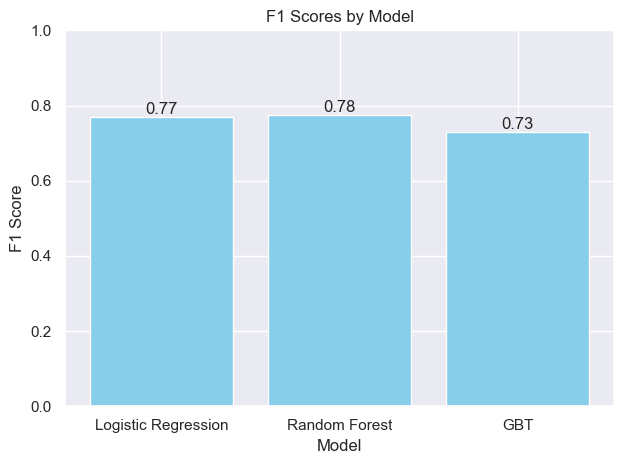

In [52]:
import numpy as np

import matplotlib.pyplot as plt

# Extract model names and F1 scores
model_names = list(f1_scores.keys())
f1_values = list(f1_scores.values())

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(model_names, f1_values, color='skyblue')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate: center of the bar
        height,  # y-coordinate: top of the bar
        f'{height:.2f}',  # Label text
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )

# Customize chart appearance
ax.set_title('F1 Scores by Model')
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1]

# Show the plot
plt.tight_layout()
plt.show()

From the training results with the above models, we see that random forest gives the best results with small datasets.

### Tuning model parameters

#### Random Forest Tuning

In [26]:
def get_rf_params(model):
    """
    Get the parameters of a trained Random Forest model.

    Args:
        model: The trained Random Forest model.

    Returns:
        dict: A dictionary of model parameters.
    """
    print("Random Forest Model Parameters:")
    params = model.extractParamMap()
    for param, value in params.items():
        print(f"{param.name}: {value}")
    return params


In [27]:
def load_model(model_name, model_class):
    """
    Load a saved model from disk.

    Args:
        model_name (str): Name of the model to load.
        model_class: The class of the model to load (e.g., LogisticRegression, RandomForestClassifier).

    Returns:
        Model: The loaded model.
    """
    load_path = os.path.join("models", model_name)
    print(f"Loading model from: {load_path}")
    return model_class.load(load_path)

Use CrossValidator with paramGrid to optimize the following RF model:
- numTrees = [50, 100]
- maxDepth = [4, 5, 6, 10]

In [38]:
def tune_random_forest(train_data, test_data, numTrees=[50, 100], maxDepth=[4, 5, 6, 10]):
    """
    Perform hyperparameter tuning for Random Forest Classifier and evaluate using multiple metrics.

    Args:
        train_data (DataFrame): Training dataset.
        test_data (DataFrame): Test dataset.

    Returns:
        dict: Best tuned model and evaluation metrics.
    """
    print("Tuning Random Forest model...")
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")
    paramGrid = ParamGridBuilder()\
        .addGrid(rf.numTrees, numTrees)\
        .addGrid(rf.maxDepth, maxDepth)\
        .build()

    # Define multiple evaluators
    evaluators = {
        "accuracy": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
        "f1": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1"),
        "weightedRecall": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall"),
    }

    crossval = CrossValidator(
        estimator=rf,
        estimatorParamMaps=paramGrid,
        evaluator=evaluators["accuracy"],  # Use accuracy for tuning
        numFolds=3
    )

    # Fit the model and get the best one
    best_rf_model = crossval.fit(train_data)
    tuned_predictions = best_rf_model.transform(test_data)

    # Evaluate using all defined metrics
    metrics = {}
    for metric_name, evaluator in evaluators.items():
        metric_value = evaluator.evaluate(tuned_predictions)
        metrics[metric_name] = metric_value
        print(f"Tuned Random Forest {metric_name.capitalize()}: {metric_value:.2f}")

    return {"model": best_rf_model, "metrics": metrics}


In [39]:
# Tune Random Forest if it is the best model
best_rf_model = tune_random_forest(train_data, test_data)

Tuning Random Forest model...
Tuned Random Forest Accuracy: 0.77
Tuned Random Forest F1: 0.76
Tuned Random Forest Weightedrecall: 0.77


#### GBTClassifier Tuning

In [41]:
def tune_gbt_classifier(train_data, test_data, maxIter=[10, 20, 50], maxDepth=[3, 5, 7]):
    """
    Perform hyperparameter tuning for Gradient Boosted Tree Classifier and evaluate using multiple metrics.

    Args:
        train_data (DataFrame): Training dataset.
        test_data (DataFrame): Test dataset.

    Returns:
        dict: Best tuned model and evaluation metrics.
    """
    print("Tuning GBTClassifier model...")
    gbt = GBTClassifier(featuresCol="features", labelCol="label")
    paramGrid = ParamGridBuilder()\
        .addGrid(gbt.maxIter, maxIter)\
        .addGrid(gbt.maxDepth, maxDepth)\
        .build()

    # Define multiple evaluators
    evaluators = {
        "accuracy": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
        "f1": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1"),
        "weightedRecall": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall"),
    }

    crossval = CrossValidator(
        estimator=gbt,
        estimatorParamMaps=paramGrid,
        evaluator=evaluators["accuracy"],  # Use accuracy for tuning
        numFolds=3
    )

    # Fit the model and get the best one
    best_gbt_model = crossval.fit(train_data)
    tuned_predictions = best_gbt_model.transform(test_data)

    # Evaluate using all defined metrics
    metrics = {}
    for metric_name, evaluator in evaluators.items():
        metric_value = evaluator.evaluate(tuned_predictions)
        metrics[metric_name] = metric_value
        print(f"Tuned GBTClassifier {metric_name.capitalize()}: {metric_value:.2f}")

    return {"model": best_gbt_model, "metrics": metrics}


In [ ]:
# Tuning GBTClassifier
gbt_results = tune_gbt_classifier(train_data, test_data)
print("GBTClassifier Metrics:", gbt_results["metrics"])

Tuning GBTClassifier model...

Tuned GBTClassifier Accuracy: 0.79

Tuned GBTClassifier F1: 0.78

Tuned GBTClassifier Weightedrecall: 0.79

GBTClassifier Metrics: {'accuracy': 0.7884615384615384, 'f1': 0.775494165277447, 'weightedRecall': 0.7884615384615385}

#### LogisticRegression Tuning

In [42]:
def tune_logistic_regression(train_data, test_data, regParam=[0.01, 0.1, 1.0], elasticNetParam=[0.0, 0.5, 1.0]):
    """
    Perform hyperparameter tuning for Logistic Regression and evaluate using multiple metrics.

    Args:
        train_data (DataFrame): Training dataset.
        test_data (DataFrame): Test dataset.

    Returns:
        dict: Best tuned model and evaluation metrics.
    """
    print("Tuning LogisticRegression model...")
    lr = LogisticRegression(featuresCol="features", labelCol="label")
    paramGrid = ParamGridBuilder()\
        .addGrid(lr.regParam, regParam)\
        .addGrid(lr.elasticNetParam, elasticNetParam)\
        .build()

    # Define multiple evaluators
    evaluators = {
        "accuracy": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
        "f1": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1"),
        "weightedRecall": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall"),
    }

    crossval = CrossValidator(
        estimator=lr,
        estimatorParamMaps=paramGrid,
        evaluator=evaluators["accuracy"],  # Use accuracy for tuning
        numFolds=3
    )

    # Fit the model and get the best one
    best_lr_model = crossval.fit(train_data)
    tuned_predictions = best_lr_model.transform(test_data)

    # Evaluate using all defined metrics
    metrics = {}
    for metric_name, evaluator in evaluators.items():
        metric_value = evaluator.evaluate(tuned_predictions)
        metrics[metric_name] = metric_value
        print(f"Tuned LogisticRegression {metric_name.capitalize()}: {metric_value:.2f}")

    return {"model": best_lr_model, "metrics": metrics}


In [43]:


# Tuning LogisticRegression
lr_results = tune_logistic_regression(train_data, test_data)
print("LogisticRegression Metrics:", lr_results["metrics"])


Tuning GBTClassifier model...
Tuned GBTClassifier Accuracy: 0.79
Tuned GBTClassifier F1: 0.78
Tuned GBTClassifier Weightedrecall: 0.79
GBTClassifier Metrics: {'accuracy': 0.7884615384615384, 'f1': 0.775494165277447, 'weightedRecall': 0.7884615384615385}
Tuning LogisticRegression model...
Tuned LogisticRegression Accuracy: 0.87
Tuned LogisticRegression F1: 0.85
Tuned LogisticRegression Weightedrecall: 0.87
LogisticRegression Metrics: {'accuracy': 0.8653846153846154, 'f1': 0.8494564934727207, 'weightedRecall': 0.8653846153846154}


In [48]:
tuning_results = {
    "Random Forest": best_rf_model["metrics"],
    "GBTClassifier": gbt_results["metrics"],
    "LogisticRegression": lr_results["metrics"]
}


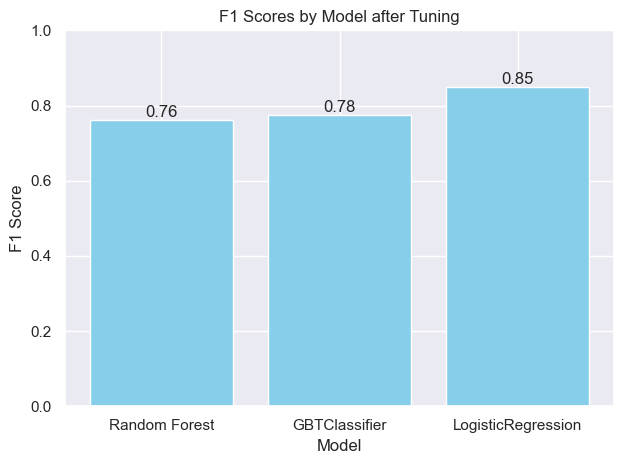

In [51]:
import numpy as np

import matplotlib.pyplot as plt

# Extract model names and their F1 scores from tuning_results
model_names = list(tuning_results.keys())
f1_values = [tuning_results[model]['f1'] for model in model_names]

# Create the bar chart
fig, ax = plt.subplots()
bars = ax.bar(model_names, f1_values, color='skyblue')

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # x-coordinate: center of the bar
        height,  # y-coordinate: top of the bar
        f'{height:.2f}',  # Label text
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )

# Customize chart appearance
ax.set_title('F1 Scores by Model after Tuning')
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_ylim(0, 1)  # Set y-axis limit to [0, 1]

# Show the plot
plt.tight_layout()
plt.show()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.